In [ ]:
!which pip
!pip list
!pip freeze > requirements.txt


/apps/software/2024a/software/Python/3.12.3-GCCcore-13.3.0/bin/pip
Package                           Version
--------------------------------- ------------
alabaster                         0.7.16
anyio                             4.3.0
appdirs                           1.4.4
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
asn1crypto                        1.5.1
asttokens                         2.4.1
async-lru                         2.0.4
atomicwrites                      1.4.1
attrs                             23.2.0
Babel                             2.15.0
backcall                          0.2.0
backports.entry_points_selectable 1.3.0
backports.functools_lru_cache     2.0.0
beautifulsoup4                    4.12.3
bitarray                          2.9.2
bitstring                         4.2.3
bleach                            6.1.0
blist                             1.3.6
CacheControl                      0.14.0
cachy                             0.3

In [1]:
import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import ListedColormap, BoundaryNorm

def visualize_single_tif(file_path, save_path=None):
    if not os.path.exists(file_path):
        print(f"Error: File not found at '{file_path}'.")
        return

    print(f"Loading image from: {file_path}")

    try:
        image_data = tf.imread(file_path)

        print(f"Data Shape: {image_data.shape}")
        print(f"Data Type (dtype): {image_data.dtype}")

        # If multi-dimensional, visualize first slice
        if image_data.ndim > 2:
            print("Detected multi-dimensional data. Visualizing the first slice.")
            image_slice = image_data[0, ...]
        else:
            image_slice = image_data

        plt.figure(figsize=(8, 8))

        # ---------------------------
        # CASE 1: Multi-label GT mask
        # ---------------------------
        if np.issubdtype(image_slice.dtype, np.integer) and image_slice.max() > 1:
            print(f"Detected multi-label segmentation mask (max label = {image_slice.max()}).")

            num_classes = len(np.unique(image_slice))
            
            # Create categorical colormap (avoid color collisions)
            base_cmap = plt.cm.get_cmap("tab20", num_classes)
            cmap = ListedColormap(base_cmap.colors[:num_classes])

            # Normalize integer boundaries
            bounds = np.arange(num_classes + 1)
            norm = BoundaryNorm(bounds, cmap.N)

            plt.imshow(image_slice, cmap=cmap, norm=norm)
            plt.title(f"Multi-Label Mask Visualization (Classes: {num_classes})")
            if num_classes < 100:
                plt.colorbar(ticks=np.arange(num_classes), label="Class ID")

        # ---------------------------
        # CASE 2: Normal grayscale image
        # ---------------------------
        else:
            plt.imshow(image_slice, cmap='gray')
            plt.title(f"Grayscale TIF Image (shape: {image_slice.shape})")
            plt.colorbar(label='Pixel Intensity')

        plt.axis('off')
        if save_path:
            plt.savefig(save_path)
        plt.show()


    except Exception as e:
        print(f"An error occurred during TIF processing: {e}")
        print("Ensure your file is a valid TIFF format and the libraries are installed.")



Loading image from: /home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01/t0804.tif
Data Shape: (1010, 1010)
Data Type (dtype): uint8
Detected multi-label segmentation mask (max label = 248).


/tmp/ipykernel_1736638/1405102149.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap("tab20", num_classes)


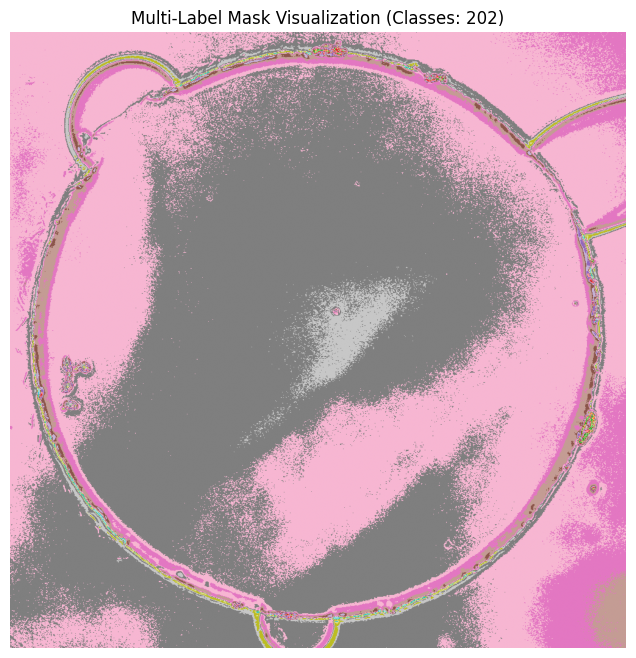

Loading image from: /home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01_ST/SEG/man_seg0804.tif
Data Shape: (1010, 1010)
Data Type (dtype): uint16
Detected multi-label segmentation mask (max label = 52).


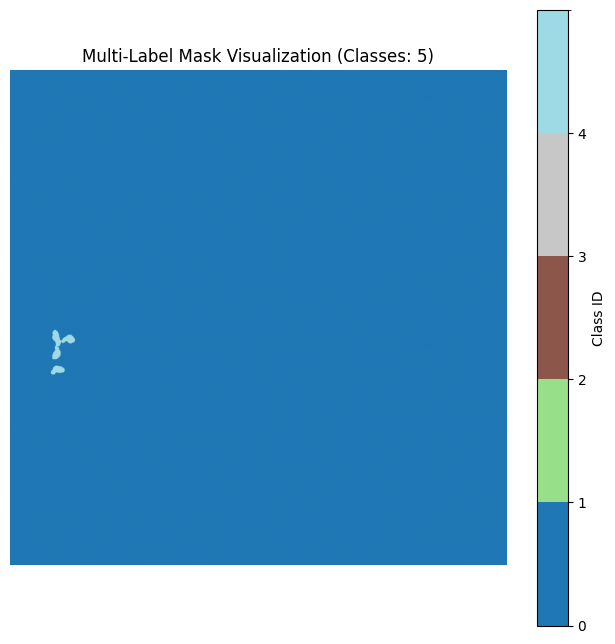

Loading image from: /home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01/t0001.tif
Data Shape: (1010, 1010)
Data Type (dtype): uint8
Detected multi-label segmentation mask (max label = 250).


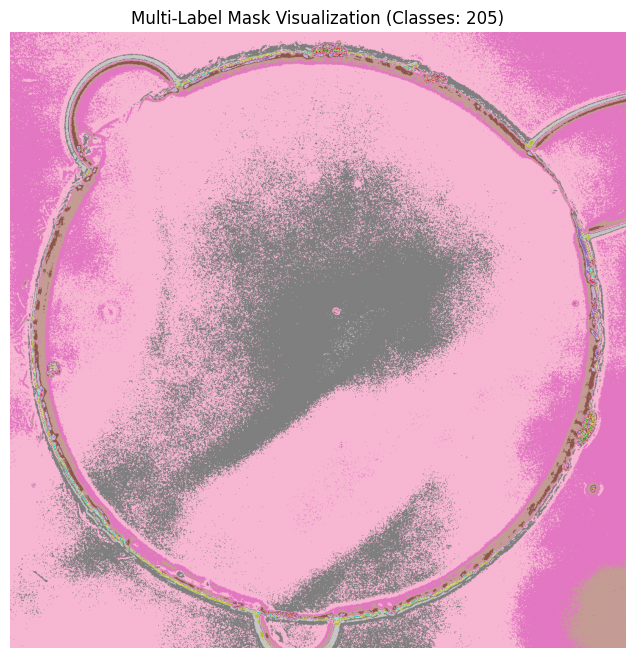

Loading image from: /home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01_ST/SEG/man_seg0001.tif
Data Shape: (1010, 1010)
Data Type (dtype): uint16


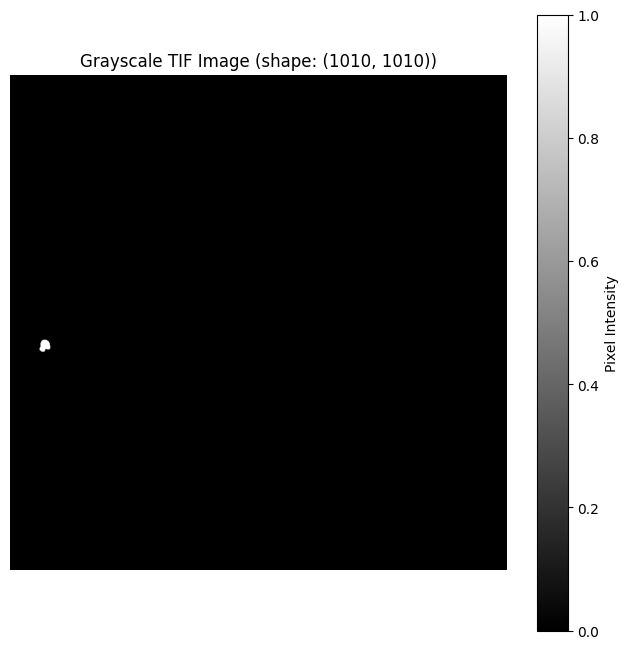

In [2]:
visualize_single_tif("/home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01/t0804.tif","/home/cpsc4710_yp338/project_images/base/multiclass.png")
visualize_single_tif("/home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01_ST/SEG/man_seg0804.tif","/home/cpsc4710_yp338/project_images/base/multiclass_gt.png")
visualize_single_tif("/home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01/t0001.tif","/home/cpsc4710_yp338/project_images/base/singleclass.png")
visualize_single_tif("/home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC/01_ST/SEG/man_seg0001.tif","/home/cpsc4710_yp338/project_images/base/single_gt.png")

In [3]:
# Helper Functions

import numpy as np
import scipy.ndimage as ndi

def make_4class_labels(mask: np.ndarray,
                       ring_width: int = 1) -> np.ndarray:
    """
    Convert an instance mask (0=background, >0=cell IDs)
    into a 4-class mask:
        0 = background
        1 = cell interior
        2 = near-cell outer ring (thin band outside cells)
        3 = between-cell interface (thin boundaries between different cells)
    """
    mask = mask.astype(np.int32)
    H, W = mask.shape

    labels = np.zeros_like(mask, dtype=np.int64)

    cell_union = mask > 0

    interface = np.zeros_like(cell_union, dtype=bool)
    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4-neighbor
        shifted = np.roll(mask, shift=(dy, dx), axis=(0, 1))
        different_nonzero = (mask > 0) & (shifted > 0) & (mask != shifted)
        interface |= different_nonzero

    labels[interface] = 3

    struct = ndi.generate_binary_structure(2, 1)
    dilated = ndi.binary_dilation(cell_union, structure=struct,
                                  iterations=ring_width)
    outer_ring = dilated & ~cell_union
    labels[outer_ring & ~interface] = 2

    cell_interior = cell_union & ~interface
    labels[cell_interior] = 1

    return labels

In [4]:
# Code for losses
import torch
import torch.nn as nn
import torch.nn.functional as F
def dice_coefficient(pred, target):
    """
    Computes the Sorensen-Dice Coefficient (DSC) for segmentation.
    
    Args:
        pred (torch.Tensor): Predicted mask (after argmax, should be 0 or 1).
        target (torch.Tensor): Ground truth mask (0 or 1).
    """
    smooth = 1e-6
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    intersection = (pred * target).sum()
    
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

# Dice loss is used for first phase training
class DiceLoss(nn.Module):
    """
    Combination of Dice Loss and Cross Entropy Loss for stable training.
    """
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy(inputs, targets)
        probs = torch.softmax(inputs, dim=1)[:, 1, :, :].float()
        targets_f = targets.float()
        
        probs_f = probs.contiguous().view(-1)
        targets_f = targets_f.contiguous().view(-1)
        
        intersection = (probs_f * targets_f).sum()
        
        dice_score = (2. * intersection) / (probs_f.sum() + targets_f.sum() + 1e-6)
        dice_loss = 1 - dice_score
        
        total_loss = ce_loss + dice_loss * 0.5 
        
        return total_loss


# Jcrossentropy Loss is used for second phase training
class JCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes: int, lambda_val: float = 0.5,
                 reg_scale: float = 1.0, eps: float = 1e-6):
        """
        num_classes: C
        lambda_val:  λ_ik (here same for all i,k)
        reg_scale:   weight for the J-regularization term
        """
        super().__init__()
        self.C = num_classes
        self.lambda_val = lambda_val
        self.reg_scale = reg_scale
        self.eps = eps

    def forward(self, logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        logits: [B, C, H, W]
        target: [B, H, W] with values in {0, ..., C-1}
        """
        B, C, H, W = logits.shape
        assert C == self.C

        z = F.softmax(logits, dim=1)    

        ce = F.cross_entropy(logits, target, reduction='mean')

        y = F.one_hot(target, num_classes=C)      
        y = y.permute(0, 3, 1, 2).float()    

        n = y.sum(dim=(0, 2, 3)) + self.eps       
        reg = logits.new_zeros(())     

        for i in range(C):
            z_i = z[:, i, :, :]                  
            y_i = y[:, i, :, :]               
            n_i = n[i]

            for k in range(C):
                y_k = y[:, k, :, :]      
                n_k = n[k]

                delta_ik = 0.5 * (y_i / n_i - y_k / n_k)

                S_ik = (z_i * delta_ik).sum()   

                val = 0.5 + S_ik

                val = torch.clamp(val, min=self.eps)

                reg = reg + self.lambda_val * torch.log(val)

        loss = ce - self.reg_scale * reg / (C * C)
        return loss



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tifffile as tf
import os
from glob import glob
from tqdm import tqdm
import segmentation_models_pytorch as smp 
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
BASE_PATH = "/home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC"
# Replace with your downloaded BF-C2DL-HSC file
VAL_SPLIT = 100 

NUM_EPOCHS = 30
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# This is for warmup training, only 2 classes
class CellSegmentationDataset(Dataset):
    """
    Custom Dataset for loading CTC-formatted TIF images and masks.
    Can combine several sequences like '01', '02', ...
    """
    def __init__(self, base_path, seq_ids=("01", "02"), indices=None):
        """
        Args:
            base_path (str): Root path to 'BF-C2DL-HSC'.
            seq_ids (iterable[str]): e.g. ("01", "02").
            indices (iterable[int] or None): frame indices (0..999). If None,
                                             try all 0..999.
        """
        self.image_paths = []
        self.mask_paths = []

        for seq in seq_ids:
            img_dir = os.path.join(base_path, seq)
            mask_dir = os.path.join(base_path, f"{seq}_ST", "SEG")
            indices = range(len(os.listdir(img_dir)))
            for idx in indices:
                idx_str = f"{idx:04d}"

                img_path = os.path.join(img_dir, f"t{idx_str}.tif")
                mask_path = os.path.join(mask_dir, f"man_seg{idx_str}.tif")

                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

        if len(self.image_paths) == 0:
            print("Warning: No valid dataset files found. Please check BASE_PATH.")
        else:
            print(f"Dataset initialized with {len(self.image_paths)} valid samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = tf.imread(self.image_paths[idx]).astype(np.float32)
        mask = tf.imread(self.mask_paths[idx])

        # normalize image
        image = (image - np.mean(image)) / (np.std(image) + 1e-6)
        image = torch.from_numpy(image).unsqueeze(0)

        # binarize mask
        mask = mask.astype(np.int64)
        mask[mask > 0] = 1
        mask = torch.from_numpy(mask)

        return image, mask

# This is for evaluation of ground truth, where there are multiple classes defined by the ground truth
class CellSegmentationDatasetGT(Dataset):
    """
    Custom Dataset for loading CTC-formatted TIF images and masks.
    Can combine several sequences like '01', '02', ...
    """
    def __init__(self, base_path, seq_ids=("01", "02"), indices=None):
        """
        Args:
            base_path (str): Root path to 'BF-C2DL-HSC'.
            seq_ids (iterable[str]): e.g. ("01", "02").
            indices (iterable[int] or None): frame indices (0..999). If None,
                                             try all 0..999.
        """
        self.image_paths = []
        self.mask_paths = []

        for seq in seq_ids:
            img_dir = os.path.join(base_path, seq)
            mask_dir = os.path.join(base_path, f"{seq}_ST", "SEG")
            indices = range(len(os.listdir(img_dir)))
            for idx in indices:
                idx_str = f"{idx:04d}"

                img_path = os.path.join(img_dir, f"t{idx_str}.tif")
                mask_path = os.path.join(mask_dir, f"man_seg{idx_str}.tif")

                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)
                # else: silently skip missing pairs

        if len(self.image_paths) == 0:
            print("Warning: No valid dataset files found. Please check BASE_PATH.")
        else:
            print(f"Dataset initialized with {len(self.image_paths)} valid samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = tf.imread(self.image_paths[idx]).astype(np.float32)
        mask = tf.imread(self.mask_paths[idx])

        # normalize image
        image = (image - np.mean(image)) / (np.std(image) + 1e-6)
        image = torch.from_numpy(image).unsqueeze(0)

        # binarize mask
        mask = mask.astype(np.int64)
        mask = torch.from_numpy(mask)

        return image, mask

# This is the dataclass for second phase 4 class training
class CellSegmentationDatasetExtraClass(Dataset):
    def __init__(self, base_path, seq_ids=("01", "02"), indices=None, ring_length=1):
        self.image_paths = []
        self.mask_paths = []
        self.ring_length = ring_length
        for seq in seq_ids:
            img_dir = os.path.join(base_path, seq)
            mask_dir = os.path.join(base_path, f"{seq}_ST", "SEG")
            indices = range(len(os.listdir(img_dir)))
            for idx in indices:
                idx_str = f"{idx:04d}"
                img_path = os.path.join(img_dir, f"t{idx_str}.tif")
                mask_path = os.path.join(mask_dir, f"man_seg{idx_str}.tif")

                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

        if len(self.image_paths) == 0:
            print("Warning: No valid dataset files found. Please check BASE_PATH.")
        else:
            print(f"Dataset initialized with {len(self.image_paths)} valid samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = tf.imread(self.image_paths[idx]).astype(np.float32)
        mask = tf.imread(self.mask_paths[idx])
        image = (image - np.mean(image)) / (np.std(image) + 1e-6)
        image = torch.from_numpy(image).unsqueeze(0)

        mask_np = mask.astype(np.int64)
        label_4class = make_4class_labels(mask_np, ring_width=self.ring_length)

        label_4class = torch.from_numpy(label_4class.astype(np.int64))

        return image, label_4class


def segmentation_accuracy_seg_measure(predicted_instance_mask, gt_instance_mask):
    """
    Computes the SEG measure (Segmentation Accuracy) based on Jaccard Index 
    and the detection matching criteria defined by the Cell Tracking Challenge.
    
    Args:
        predicted_instance_mask (np.ndarray): Predicted mask with instance IDs (S).
        gt_instance_mask (np.ndarray): Ground truth mask with instance IDs (R).
        
    Returns:
        float: The mean Jaccard Index (SEG Score) for all reference objects.
    """
    ref_ids = np.unique(gt_instance_mask)
    ref_ids = ref_ids[ref_ids != 0]
    if len(ref_ids) == 0:
        return 1.0 

    jaccard_scores = []

    for ref_id in ref_ids:
        R_mask = (gt_instance_mask == ref_id)
        R_area = R_mask.sum()
        
        if R_area == 0: continue
            
        S_overlap_ids = np.unique(predicted_instance_mask[R_mask])
        S_overlap_ids = S_overlap_ids[S_overlap_ids != 0]
        best_match_j = 0.0

        for pred_id in S_overlap_ids:
            S_mask = (predicted_instance_mask == pred_id)
            
            intersection_mask = R_mask & S_mask
            intersection_area = intersection_mask.sum()
            
            if intersection_area / R_area > 0.5:
                S_area = S_mask.sum()
                union_area = R_area + S_area - intersection_area
                
                jaccard_index = intersection_area / union_area if union_area > 0 else 0.0
                
                if jaccard_index > best_match_j:
                    best_match_j = jaccard_index
        
        jaccard_scores.append(best_match_j)

    return np.mean(jaccard_scores)

def evaluate_model_SEG(
    model,
    dataloader,
    seg_fail_threshold: float = 0.4,
    visualize_failures: bool = True,
):
    model.eval()
    total_seg = 0.0
    total_samples = 0

    failure_visualized = False  # make sure we only show ONE failure case

    with torch.no_grad():
        for inputs, gt_instance_masks in tqdm(dataloader, desc="Validation epoch"):
            inputs = inputs.to(DEVICE)

            # forward pass
            outputs = model(inputs)           # [B, 4, H, W]
            pred = torch.argmax(outputs, dim=1)  # [B, H, W], values 0..3

            fg = (pred == 1)  # bool mask for class 1
            fg_sep = fg

            fg_sep_np = fg_sep.cpu().numpy().astype(np.int32)
            pred_np_full = pred.cpu().numpy().astype(np.int32)  # full 0..3 labels

            B = inputs.size(0)
            for i in range(B):
                gt_instance_mask_np = gt_instance_masks[i].cpu().numpy().astype(np.int32)

                preds_binary_np = fg_sep_np[i]
                # if len(np.unique(gt_instance_mask_np)) != 2:
                #     print(f"Sample {i}: binary prediction not truly binary")
                    # print("Binary pixel counts:", np.unique(preds_binary_np, return_counts=True))

                # connected-component labeling -> predicted instances S
                preds_instance_np, _ = label(preds_binary_np, structure=None)

                # SEG score for this image
                current_seg_score = segmentation_accuracy_seg_measure(
                    preds_instance_np,
                    gt_instance_mask_np,
                )

                total_seg += current_seg_score
                total_samples += 1

                # ---- visualize failure case if below threshold and not yet plotted ----
                if (
                    visualize_failures
                    and not failure_visualized
                    and current_seg_score < seg_fail_threshold
                ):
                    failure_visualized = True
                    print(f"\n=== SEG failure case (SEG={current_seg_score:.4f}) ===")

                    # pixel counts per predicted *class* (0..3) for this image
                    pred_classes_img = pred_np_full[i]  # shape [H, W], values 0..3
                    classes, counts = np.unique(pred_classes_img, return_counts=True)
                    print("Predicted class pixel counts (class -> count):")
                    print({int(c): int(k) for c, k in zip(classes, counts)})

                    # if you also want GT instance-id distribution:
                    gt_ids, gt_counts = np.unique(gt_instance_mask_np, return_counts=True)
                    print("GT instance-id pixel counts (id -> count):")
                    print({int(c): int(k) for c, k in zip(gt_ids, gt_counts)})

                    # ---- basic visualization ----
                    # assume inputs: [B, C, H, W]; we visualize the first 3 channels if possible
                    inp_img = inputs[i].detach().cpu()
                    if inp_img.dim() == 3:
                        # [C, H, W] -> [H, W, C]
                        inp_img_vis = inp_img.permute(1, 2, 0).numpy()
                        # if single-channel, squeeze
                        if inp_img_vis.shape[2] == 1:
                            inp_img_vis = inp_img_vis[:, :, 0]
                    else:
                        # degenerate case: already [H, W]
                        inp_img_vis = inp_img.numpy()

                    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                    axs[0].set_title("Input image")
                    axs[0].imshow(inp_img_vis, cmap="gray")
                    axs[0].axis("off")

                    axs[1].set_title("GT instance mask")
                    im1 = axs[1].imshow(gt_instance_mask_np, cmap="tab20")
                    axs[1].axis("off")
                    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

                    axs[2].set_title("Predicted instances (CCL on class 1)")
                    im2 = axs[2].imshow(preds_instance_np, cmap="tab20")
                    axs[2].axis("off")
                    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

                    fig.suptitle(f"SEG failure (SEG={current_seg_score:.4f})", fontsize=14)
                    plt.tight_layout()
                    plt.show()

    avg_seg = total_seg / total_samples if total_samples > 0 else 0.0
    return avg_seg

def evaluate_model_SEG_multiclass(
    model,
    dataloader,
    seg_fail_threshold: float = 0.4,
    visualize_failures: bool = True,
):
    model.eval()
    total_seg = 0.0
    total_samples = 0

    failure_visualized = False  # make sure we only show ONE failure case

    with torch.no_grad():
        for inputs, gt_instance_masks in tqdm(dataloader, desc="Validation epoch"):
            inputs = inputs.to(DEVICE)
            if len(np.unique(gt_instance_masks) == 2) :
                continue
            print(f"Evaluating!")
            # forward pass
            outputs = model(inputs)           # [B, 4, H, W]
            pred = torch.argmax(outputs, dim=1)  # [B, H, W], values 0..3

            fg = (pred == 1)  # bool mask for class 1
            fg_sep = fg

            fg_sep_np = fg_sep.cpu().numpy().astype(np.int32)
            pred_np_full = pred.cpu().numpy().astype(np.int32)  # full 0..3 labels

            B = inputs.size(0)
            for i in range(B):
                gt_instance_mask_np = gt_instance_masks[i].cpu().numpy().astype(np.int32)

                preds_binary_np = fg_sep_np[i]
                if len(np.unique(preds_binary_np)) != 2:
                    print(f"Sample {i}: binary prediction not truly binary")
                    print("Binary pixel counts:", np.unique(preds_binary_np, return_counts=True))

                # connected-component labeling -> predicted instances S
                preds_instance_np, _ = label(preds_binary_np, structure=None)

                # SEG score for this image
                current_seg_score = segmentation_accuracy_seg_measure(
                    preds_instance_np,
                    gt_instance_mask_np,
                )

                total_seg += current_seg_score
                total_samples += 1

                # ---- visualize failure case if below threshold and not yet plotted ----
                if (
                    visualize_failures
                    and not failure_visualized
                    and current_seg_score < seg_fail_threshold
                ):
                    failure_visualized = True
                    print(f"\n=== SEG failure case (SEG={current_seg_score:.4f}) ===")

                    # pixel counts per predicted *class* (0..3) for this image
                    pred_classes_img = pred_np_full[i]  # shape [H, W], values 0..3
                    classes, counts = np.unique(pred_classes_img, return_counts=True)
                    print("Predicted class pixel counts (class -> count):")
                    print({int(c): int(k) for c, k in zip(classes, counts)})

                    # if you also want GT instance-id distribution:
                    gt_ids, gt_counts = np.unique(gt_instance_mask_np, return_counts=True)
                    print("GT instance-id pixel counts (id -> count):")
                    print({int(c): int(k) for c, k in zip(gt_ids, gt_counts)})

                    # ---- basic visualization ----
                    # assume inputs: [B, C, H, W]; we visualize the first 3 channels if possible
                    inp_img = inputs[i].detach().cpu()
                    if inp_img.dim() == 3:
                        # [C, H, W] -> [H, W, C]
                        inp_img_vis = inp_img.permute(1, 2, 0).numpy()
                        # if single-channel, squeeze
                        if inp_img_vis.shape[2] == 1:
                            inp_img_vis = inp_img_vis[:, :, 0]
                    else:
                        # degenerate case: already [H, W]
                        inp_img_vis = inp_img.numpy()

                    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                    axs[0].set_title("Input image")
                    axs[0].imshow(inp_img_vis, cmap="gray")
                    axs[0].axis("off")

                    axs[1].set_title("GT instance mask")
                    im1 = axs[1].imshow(gt_instance_mask_np, cmap="tab20")
                    axs[1].axis("off")
                    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

                    axs[2].set_title("Predicted instances (CCL on class 1)")
                    im2 = axs[2].imshow(preds_instance_np, cmap="tab20")
                    axs[2].axis("off")
                    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

                    fig.suptitle(f"SEG failure (SEG={current_seg_score:.4f})", fontsize=14)
                    plt.tight_layout()
                    plt.show()

    avg_seg = total_seg / total_samples if total_samples > 0 else 0.0
    return avg_seg



Using device: cuda


In [6]:
# Train & eval

def train_model(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, masks in tqdm(dataloader,desc="Training epoch"):
        inputs = inputs.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        preds = torch.softmax(outputs,dim = 1).cpu().detach().numpy()
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    if len(dataloader.dataset) > 0:
        epoch_loss = running_loss / len(dataloader.dataset)
    else:
        epoch_loss = 0.0
    return epoch_loss

# Evaluate first phase normal segmentation training
def evaluate_model(model, dataloader):
    model.eval()
    total_dice = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, masks in tqdm(dataloader, desc="Validation epoch"):
            inputs = inputs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            preds_binary = preds.clone()
            masks_binary = masks.clone()

            preds_binary[preds_binary > 1] = 0
            masks_binary[masks_binary > 1] = 0

            batch_dice = 0.0
            B = inputs.size(0)
            for i in range(B):
                batch_dice += dice_coefficient(preds_binary[i], masks_binary[i])

            total_dice += batch_dice
            total_samples += B

    avg_dice = total_dice / total_samples
    return avg_dice




# Used to evaluate ground truth segmentation performance
def evaluate_model_SEG(
    model,
    dataloader,
    seg_fail_threshold: float = 0.4,
    visualize_failures: bool = True,
):
    model.eval()
    total_seg = 0.0
    total_samples = 0

    failure_visualized = False

    with torch.no_grad():
        for inputs, gt_instance_masks in tqdm(dataloader, desc="Validation epoch"):
            inputs = inputs.to(DEVICE)

            outputs = model(inputs) 
            pred = torch.argmax(outputs, dim=1)

            fg = (pred == 1)
            fg_sep = fg

            fg_sep_np = fg_sep.cpu().numpy().astype(np.int32)
            pred_np_full = pred.cpu().numpy().astype(np.int32)

            B = inputs.size(0)
            for i in range(B):
                gt_instance_mask_np = gt_instance_masks[i].cpu().numpy().astype(np.int32)

                preds_binary_np = fg_sep_np[i]
                preds_instance_np, _ = label(preds_binary_np, structure=None)

                current_seg_score = segmentation_accuracy_seg_measure(
                    preds_instance_np,
                    gt_instance_mask_np,
                )

                total_seg += current_seg_score
                total_samples += 1

                if (
                    visualize_failures
                    and not failure_visualized
                    and current_seg_score < seg_fail_threshold
                ):
                    failure_visualized = True
                    print(f"\n=== SEG failure case (SEG={current_seg_score:.4f}) ===")

                    pred_classes_img = pred_np_full[i]
                    classes, counts = np.unique(pred_classes_img, return_counts=True)
                    print("Predicted class pixel counts (class -> count):")
                    print({int(c): int(k) for c, k in zip(classes, counts)})

                    gt_ids, gt_counts = np.unique(gt_instance_mask_np, return_counts=True)
                    print("GT instance-id pixel counts (id -> count):")
                    print({int(c): int(k) for c, k in zip(gt_ids, gt_counts)})

                    inp_img = inputs[i].detach().cpu()
                    if inp_img.dim() == 3:

                        inp_img_vis = inp_img.permute(1, 2, 0).numpy()
                        if inp_img_vis.shape[2] == 1:
                            inp_img_vis = inp_img_vis[:, :, 0]
                    else:
                        inp_img_vis = inp_img.numpy()

                    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                    axs[0].set_title("Input image")
                    axs[0].imshow(inp_img_vis, cmap="gray")
                    axs[0].axis("off")

                    axs[1].set_title("GT instance mask")
                    im1 = axs[1].imshow(gt_instance_mask_np, cmap="tab20")
                    axs[1].axis("off")
                    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

                    axs[2].set_title("Predicted instances (CCL on class 1)")
                    im2 = axs[2].imshow(preds_instance_np, cmap="tab20")
                    axs[2].axis("off")
                    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

                    fig.suptitle(f"SEG failure (SEG={current_seg_score:.4f})", fontsize=14)
                    plt.tight_layout()
                    plt.show()

    avg_seg = total_seg / total_samples if total_samples > 0 else 0.0
    return avg_seg

# Used to evaluate second phase training (4 class)
def evaluate_model_SEG_multiclass(
    model,
    dataloader,
    seg_fail_threshold: float = 0.4,
    visualize_failures: bool = True,
):
    model.eval()
    total_seg = 0.0
    total_samples = 0

    failure_visualized = False

    with torch.no_grad():
        for inputs, gt_instance_masks in tqdm(dataloader, desc="Validation epoch"):
            inputs = inputs.to(DEVICE)
            if len(np.unique(gt_instance_masks) == 2) :
                continue
            print(f"Evaluating!")
            outputs = model(inputs)     
            pred = torch.argmax(outputs, dim=1)

            fg = (pred == 1)  
            fg_sep = fg

            fg_sep_np = fg_sep.cpu().numpy().astype(np.int32)
            pred_np_full = pred.cpu().numpy().astype(np.int32) 

            B = inputs.size(0)
            for i in range(B):
                gt_instance_mask_np = gt_instance_masks[i].cpu().numpy().astype(np.int32)

                preds_binary_np = fg_sep_np[i]
                # if len(np.unique(preds_binary_np)) != 2:
                #     print(f"Sample {i}: binary prediction not truly binary")
                #     print("Binary pixel counts:", np.unique(preds_binary_np, return_counts=True))

                preds_instance_np, _ = label(preds_binary_np, structure=None)

                # SEG score for this image
                current_seg_score = segmentation_accuracy_seg_measure(
                    preds_instance_np,
                    gt_instance_mask_np,
                )

                total_seg += current_seg_score
                total_samples += 1

                # if (
                #     visualize_failures
                #     and not failure_visualized
                #     and current_seg_score < seg_fail_threshold
                # ):
                #     failure_visualized = True
                #     print(f"\n=== SEG failure case (SEG={current_seg_score:.4f}) ===")

                #     # pixel counts per predicted *class* (0..3) for this image
                #     pred_classes_img = pred_np_full[i]  # shape [H, W], values 0..3
                #     classes, counts = np.unique(pred_classes_img, return_counts=True)
                #     print("Predicted class pixel counts (class -> count):")
                #     print({int(c): int(k) for c, k in zip(classes, counts)})

                #     # if you also want GT instance-id distribution:
                #     gt_ids, gt_counts = np.unique(gt_instance_mask_np, return_counts=True)
                #     print("GT instance-id pixel counts (id -> count):")
                #     print({int(c): int(k) for c, k in zip(gt_ids, gt_counts)})

                #     # ---- basic visualization ----
                #     # assume inputs: [B, C, H, W]; we visualize the first 3 channels if possible
                #     inp_img = inputs[i].detach().cpu()
                #     if inp_img.dim() == 3:
                #         # [C, H, W] -> [H, W, C]
                #         inp_img_vis = inp_img.permute(1, 2, 0).numpy()
                #         # if single-channel, squeeze
                #         if inp_img_vis.shape[2] == 1:
                #             inp_img_vis = inp_img_vis[:, :, 0]
                #     else:
                #         # degenerate case: already [H, W]
                #         inp_img_vis = inp_img.numpy()

                #     fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                #     axs[0].set_title("Input image")
                #     axs[0].imshow(inp_img_vis, cmap="gray")
                #     axs[0].axis("off")

                #     axs[1].set_title("GT instance mask")
                #     im1 = axs[1].imshow(gt_instance_mask_np, cmap="tab20")
                #     axs[1].axis("off")
                #     fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

                #     axs[2].set_title("Predicted instances (CCL on class 1)")
                #     im2 = axs[2].imshow(preds_instance_np, cmap="tab20")
                #     axs[2].axis("off")
                #     fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

                #     fig.suptitle(f"SEG failure (SEG={current_seg_score:.4f})", fontsize=14)
                #     plt.tight_layout()
                #     plt.show()

    avg_seg = total_seg / total_samples if total_samples > 0 else 0.0
    return avg_seg



In [9]:
# Training data for phase 1 training

from torch.utils.data import random_split

full_dataset = CellSegmentationDataset(
    BASE_PATH,
    seq_ids=("01", "02"),
    indices=None
)

if len(full_dataset) == 0:
    print("\nFATAL ERROR: No data found. Please check BASE_PATH.")
else:
    # 2. Randomly split: 90% train, 10% val
    num_total = len(full_dataset)
    num_val = max(1, int(0.1 * num_total))
    num_train = num_total - num_val

    train_dataset, val_dataset = random_split(
        full_dataset,
        lengths=[num_train, num_val],
        generator=torch.Generator().manual_seed(42)  # reproducible split
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

Dataset initialized with 3528 valid samples.


In [ ]:
# Training code for phase 1, uncomment first and train the phase 1 model. We have already trained this and uploaded the optimal model.

# NUM_EPOCHS = 30
# model = smp.Unet(
#     encoder_name="resnet34",    
#     encoder_weights="imagenet",  
#     in_channels=1,               
#     classes=2,          
# ).to(DEVICE)

# print(f"Initialized pre-trained UNet with ResNet34 encoder.")

# criterion = DiceLoss()
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# print(f"\n--- Starting Training on {len(train_dataset)} samples ---")

# best_val_dice = 0.0

# for epoch in range(NUM_EPOCHS):
#     train_loss = train_model(model, train_loader, criterion, optimizer)
#     val_dice = evaluate_model(model, val_loader)

#     print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
#     print(f"  Train Loss: {train_loss:.4f}")
#     print(f"  Validation Dice Coeff: {val_dice:.4f}")

#     if val_dice > best_val_dice:
#         best_val_dice = val_dice
#         torch.save(model.state_dict(), "test.pth")
#         print("  -> Saved new best model!")
        
# print("\n--- Training Complete ---")
# print(f"Best Validation Dice Coefficient: {best_val_dice:.4f}")

# model.load_state_dict(torch.load("test.pth"))

# final_dice = evaluate_model(model, val_loader) 
# print(f"Final Test/Validation Dice Coefficient: {final_dice:.4f}")

In [16]:
# Evaluating phase 1 results

import segmentation_models_pytorch as smp 
from scipy.ndimage import label 

BASE_PATH = "/home/cpsc4710_yp338/BF-C2DL-HSC-train/BF-C2DL-HSC"
MODEL_PATH = "best_unet_model_pretrained.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights=None,          
    in_channels=1,                 
    classes=2,                    
).to(DEVICE)

if not os.path.exists(MODEL_PATH):
    print(f"\nFATAL ERROR: Model weights not found at '{MODEL_PATH}'.")
    print("Please train the model first and ensure 'best_unet_model_pretrained.pth' is in the same directory.")
else:
    print(f"\nLoading weights from: {MODEL_PATH}")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    all_dice_scores = []
    all_seg_scores = []
    
    test_iterator = iter(val_loader)
    for i in range(len(val_loader)):
        
        try:
            inputs, gt_instance_mask_t = next(test_iterator)
        except StopIteration:
            print(f"Only processed {i} samples. End of dataset reached.")
            if i > 0:
                fig.set_size_inches(12, 4 * i)
            break
        inputs = inputs.to(DEVICE)
        gt_instance_mask_np = gt_instance_mask_t.squeeze(0).numpy()
        
        gt_binary_mask_t = (gt_instance_mask_t > 0).float()
        
        with torch.no_grad():
            outputs = model(inputs)
        
        preds_binary_t = torch.argmax(outputs, dim=1)
        preds_binary_np = preds_binary_t.squeeze(0).cpu().numpy()
        
        current_dice = dice_coefficient(
            preds_binary_t.float(), 
            gt_binary_mask_t.to(DEVICE).float()
        )
        all_dice_scores.append(current_dice.cpu())
        
        preds_instance_np = preds_binary_np
        
        input_image_np = inputs.squeeze().cpu().numpy()
        
    if all_dice_scores:
        avg_dice = np.mean(all_dice_scores)
        print(f"\n--- Evaluation Summary for Visualized Samples ---")
        print(f"Average Dice Score: {avg_dice:.4f}")


Loading weights from: best_unet_model_pretrained.pth

--- Evaluation Summary for Visualized Samples ---
Average Dice Score: 0.9821


In [17]:
# Build Dataset for multic-class setting, where previous model should struggle

from torch.utils.data import random_split

full_dataset_GT = CellSegmentationDatasetGT(
    BASE_PATH,
    seq_ids=("01", "02"), 
    indices=None  
)

if len(full_dataset) == 0:
    print("\nFATAL ERROR: No data found. Please check BASE_PATH.")
else:
    num_total = len(full_dataset)
    num_val = max(1, int(0.1 * num_total))
    num_train = num_total - num_val

    train_dataset, val_dataset = random_split(
        full_dataset_GT,
        lengths=[num_train, num_val],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader_GT = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_GT   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
    print(len(val_loader_GT))

Dataset initialized with 3528 valid samples.
88


In [19]:
# Evaluate phase 1 model on multi-class setting. Traditional segmentation will struggle, leaderboard methods can achive ~0.850

model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights=None,          
    in_channels=1,                 
    classes=2,                    
).to(DEVICE)
cnt = 0
if not os.path.exists(MODEL_PATH):
    print(f"\nFATAL ERROR: Model weights not found at '{MODEL_PATH}'.")
    print("Please train the model first and ensure 'best_unet_model_pretrained.pth' is in the same directory.")
else:
    print(f"\nLoading weights from: {MODEL_PATH}")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval() 
    all_seg_scores = [] 

    test_iterator = iter(val_loader_GT)
    for i in range(len(val_loader_GT)):
        
        try:
            inputs, gt_instance_mask_t = next(test_iterator)
        except StopIteration:
            print(f"Only processed {i} samples. End of dataset reached.")
            if i > 0:
                fig.set_size_inches(12, 4 * i)
            break
        inputs = inputs.to(DEVICE)
        gt_instance_mask_np = gt_instance_mask_t.squeeze(0).numpy() 
        
        gt_binary_mask_t = (gt_instance_mask_t > 0).float()
        
        with torch.no_grad():
            outputs = model(inputs)
        
        preds_binary_t = torch.argmax(outputs, dim=1)
        preds_binary_np = preds_binary_t.squeeze(0).cpu().numpy()
        
        preds_instance_np, _  = label(preds_binary_np, structure=None)
        current_seg_score = segmentation_accuracy_seg_measure(preds_instance_np, gt_instance_mask_np)
        all_seg_scores.append(current_seg_score)
        input_image_np = inputs.squeeze().cpu().numpy()

    # Print overall average scores for the visualized batch
    if all_seg_scores:
        avg_seg = np.mean(all_seg_scores)
        print(f"\n--- Evaluation Summary---")
        print(f"Average SEG Score (Instance Accuracy): {avg_seg:.4f}")


Loading weights from: best_unet_model_pretrained.pth

--- Evaluation Summary---
Average SEG Score (Instance Accuracy): 0.1434


In [16]:
# Helper visualization function
import matplotlib.pyplot as plt

def visualize_samples(dataset, k):
    """
    Plot original image, original instance mask, and 4-class labels
    for the first n samples.
    """
    fig, axes = plt.subplots(1, 3, figsize=(10, 3 * 1))

    img = tf.imread(dataset.image_paths[k]).astype(np.float32)
    raw_mask = tf.imread(dataset.mask_paths[k]).astype(np.int64)

    # 4-class label
    label_4class = make_4class_labels(raw_mask, ring_width=1)
    print(np.unique(label_4class))
    ax_img, ax_raw, ax_lbl = axes

    ax_img.imshow(img, cmap="gray")
    ax_img.set_title("Raw image")
    ax_img.axis("off")

    ax_raw.imshow(raw_mask, cmap="tab20")
    ax_raw.set_title("Original instance mask")
    ax_raw.axis("off")

    im = ax_lbl.imshow(label_4class, cmap="tab10", vmin=0, vmax=3)
    ax_lbl.set_title("4-class label (0/1/2/3)")
    ax_lbl.axis("off")

    plt.tight_layout()
    plt.show()


In [21]:
# Setup data used to evaluate 4 class training. Note that this result is not the final multi-class segmentation we want

full_dataset_extra_class = CellSegmentationDatasetExtraClass(
    BASE_PATH,
    seq_ids=("01", "02"),
    indices=None,
    ring_length = 5
)


num_total = len(full_dataset_extra_class)
num_val = max(1, int(0.1 * num_total))
num_train = num_total - num_val

train_dataset_extra_class, val_dataset_extra_class = random_split(
    full_dataset_extra_class,
    lengths=[num_train, num_val],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

# 3. DataLoaders
train_loader_extra_class = DataLoader(train_dataset_extra_class, batch_size=BATCH_SIZE, shuffle=True)
val_loader_extra_class   = DataLoader(val_dataset_extra_class,   batch_size=BATCH_SIZE, shuffle=False)


Dataset initialized with 3528 valid samples.


In [ ]:
# Load from warmup and prepare for 4 class training uncomment if you want to train the 4 class model. We have uplaoded the optimal 4 class model.

# import torch
# import segmentation_models_pytorch as smp

# DEVICE = "cuda" 
# two_class_ckpt = "./best_unet_model_pretrained.pth"
# model_2c = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights="imagenet",
#     in_channels=1,
#     classes=2,
# ).to(DEVICE)
# model_2c.load_state_dict(torch.load(two_class_ckpt, map_location=DEVICE))

# # 2. Create a new 4-class model
# model_4c = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights=None, 
#     in_channels=1,
#     classes=4,  
# ).to(DEVICE)

# state_2c = model_2c.state_dict()
# state_4c = model_4c.state_dict()

# filtered_state = {
#     k: v for k, v in state_2c.items()
#     if k in state_4c and state_4c[k].shape == v.shape
# }

# state_4c.update(filtered_state)
# model_4c.load_state_dict(state_4c)

# print("Loaded encoder+decoder weights from 2-class model into 4-class model.")


In [26]:
# Load trained 4c model

import torch
import segmentation_models_pytorch as smp

best_model_4c_path = "./best_unet_4c_model_pretrained.pth"
model_4c = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=4,      
).to(DEVICE)
best_model_4c = torch.load(best_model_4c_path)
model_4c.load_state_dict(best_model_4c)



<All keys matched successfully>

In [23]:
# Code to evaluate 4-class training

def evaluate_multiclass_metrics(model, dataloader, num_classes=4):
    model.eval()

    correct_per_class = [0 for _ in range(num_classes)]
    total_per_class   = [0 for _ in range(num_classes)]

    intersection = [0 for _ in range(num_classes)]
    union        = [0 for _ in range(num_classes)]
    pred_sum     = [0 for _ in range(num_classes)]
    gt_sum       = [0 for _ in range(num_classes)]

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Eval per-class"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)  

            logits = model(images)     
            preds = torch.argmax(logits, dim=1) 

            for cls in range(num_classes):
                gt_mask   = (labels == cls)
                pred_mask = (preds  == cls)

                correct_per_class[cls] += (pred_mask & gt_mask).sum().item()
                total_per_class[cls]   += gt_mask.sum().item()

                intersection[cls] += (pred_mask & gt_mask).sum().item()
                pred_sum[cls]      += pred_mask.sum().item()
                gt_sum[cls]        += gt_mask.sum().item()

                union[cls] += ((pred_mask | gt_mask).sum().item())

    metrics = {}

    for cls in range(num_classes):
        if total_per_class[cls] == 0:
            metrics[f"acc_class_{cls}"] = float('nan')
        else:
            metrics[f"acc_class_{cls}"] = correct_per_class[cls] / total_per_class[cls]

    for cls in range(num_classes):
        if pred_sum[cls] + gt_sum[cls] == 0:
            metrics[f"dice_class_{cls}"] = float('nan')
        else:
            metrics[f"dice_class_{cls}"] = (
                2 * intersection[cls] / (pred_sum[cls] + gt_sum[cls])
            )

    for cls in range(num_classes):
        if union[cls] == 0:
            metrics[f"iou_class_{cls}"] = float('nan')
        else:
            metrics[f"iou_class_{cls}"] = intersection[cls] / union[cls]

    return metrics


In [ ]:
# Training code for 4 class

# NUM_EPOCHS_4c = 30

# criterion = JCrossEntropyLoss(num_classes=4, lambda_val=0.5, reg_scale=1.0)
# LEARNING_RATE = 1e-3
# optimizer = optim.Adam(model_4c.parameters(), lr=LEARNING_RATE)

# print(f"\n--- Starting 4 classTraining on {len(train_dataset)} samples ---")

# # 3. Training Loop
# best_val_dice = 0.0
# val_dice = evaluate_model_SEG(model_4c, val_loader)
# val_metrics = evaluate_multiclass_metrics(model_4c, val_loader_extra_class)
# print(f"Val metrics {val_metrics}")
# for epoch in range(NUM_EPOCHS):
#     train_loss = train_model(model_4c, train_loader_extra_class, criterion, optimizer)
#     val_dice = evaluate_model_SEG(model_4c, val_loader)
#     val_metrics = evaluate_multiclass_metrics(model_4c, val_loader_extra_class)
#     print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
#     print(f"  Train Loss: {train_loss:.4f}")
#     print(f"  Validation SEG: {val_dice:.4f}")
#     print(f"Val metrics {val_metrics}")
#     # Simple saving of the best model based on validation Dice score
#     if val_dice > best_val_dice:
#         best_val_dice = val_dice
#         torch.save(model_4c.state_dict(), "test.pth")
#         print("  -> Saved new best model!")
        
# print("\n--- Training Complete ---")
# print(f"Best Validation SEG Coefficient: {best_val_dice:.4f}")

# 4. Final Evaluation (Optional, but good practice)
# Reload the best model for final evaluation
# model_4c.load_state_dict(torch.load("best_unet_4c_model_pretrained.pth"))

# final_SEG = evaluate_model_SEG(model_4c, val_loader_extra_class) 
# print(f"Final Test/Validation SEG: {final_SEG:.4f}")

# final_dice = evaluate_model(model_4c, val_loader_extra_class) 
# print(f"Final Test/Validation Dice Coefficient: {final_dice:.4f}")

Validation epoch:   0%|          | 0/88 [00:00<?, ?it/s]


=== SEG failure case (SEG=0.0392) ===
Predicted class pixel counts (class -> count):
{0: 997345, 1: 22755}
GT instance-id pixel counts (id -> count):
{0: 997413, 85: 572, 110: 404, 113: 331, 119: 304, 123: 277, 125: 362, 126: 339, 128: 351, 129: 372, 130: 414, 132: 325, 133: 340, 135: 348, 137: 299, 139: 343, 142: 337, 145: 385, 147: 340, 148: 328, 150: 312, 153: 310, 155: 387, 157: 379, 159: 365, 160: 330, 164: 316, 166: 366, 176: 307, 177: 295, 179: 387, 180: 303, 181: 279, 183: 328, 184: 293, 186: 245, 196: 280, 197: 279, 198: 331, 200: 320, 203: 292, 205: 310, 206: 250, 208: 277, 220: 308, 221: 333, 223: 289, 224: 330, 228: 229, 230: 274, 231: 308, 232: 278, 234: 371, 235: 317, 238: 272, 239: 278, 241: 261, 242: 262, 244: 269, 245: 233, 247: 279, 248: 294, 250: 260, 251: 236, 253: 268, 254: 286, 255: 206, 257: 237, 259: 226, 260: 242, 262: 286, 263: 284, 625: 327, 626: 332}


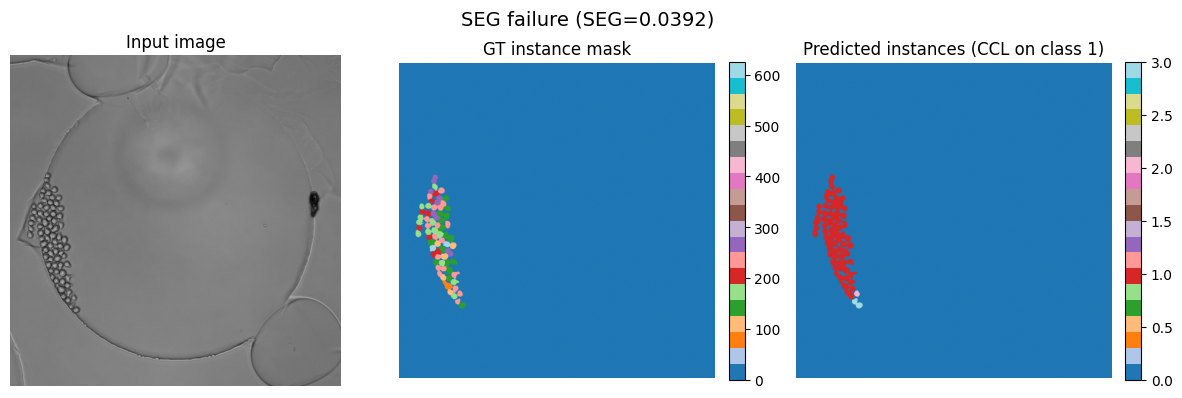

Validation epoch: 100%|██████████| 88/88 [00:28<00:00,  3.11it/s]


Normal segmentation model SEG score: 0.5193715692301742


Validation epoch: 100%|██████████| 88/88 [00:27<00:00,  3.18it/s]

4 Class segmentation model SEG score: 0.9051737057673083


In [27]:
cnt = 0
model_4c.eval()
val_dice = evaluate_model_SEG(model, val_loader_GT)
print(f"Normal segmentation model SEG score: {val_dice}")
val_dice_4c = evaluate_model_SEG(model_4c, val_loader_GT)
print(f"4 Class segmentation model SEG score: {val_dice_4c}")
#print(val_dice_original)

In [ ]:
#The comparison highlights that the boundary-aware 4-class model substantially improves multi-cell segmentation performance. While the normal 2-class model struggles to separate tightly clustered cells—often merging adjacent nuclei into a single connected component—the boundary-aware model explicitly learns ring and inter-cell regions, enabling it to delineate individual instances more accurately. This is reflected in the noticeably cleaner predicted instance map and the higher SEG score, demonstrating the model’s ability to handle dense, overlapping cell configurations that confound standard foreground–background segmentation.
